In [393]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import pandas as pd
import scipy
import math

%matplotlib inline  

In [412]:
def iter_kmeans(points, k, epochs=10000):
    not_finished = True
    centroids = points[np.random.choice(points.shape[0], k, replace=False), :]
    epoch = 0
    labels = []
    
    while not_finished and epoch < epochs:
        labels = []
        for i in range(k):
            labelled_points.append([])

        for point in points:
            shortest_i, shortest_distance = 0, 100000000000
            for i, centroid in enumerate(centroids):
                distance = scipy.spatial.distance.euclidean(point, centroid)
                if distance < shortest_distance:
                    shortest_distance = distance
                    shortest_i = i
            labels.append(shortest_i)

        labels = np.array(labels)
        not_finished = False

        for i in range(k):
            new_centroid = np.mean(points[np.where(labels == i)], axis=0)
            if not np.all(np.isclose(new_centroid, centroids[i])):
                centroids[i] = new_centroid
                not_finished = True

#        if epoch != 0  and epoch % 1000 == 0:
        epoch = epoch + 1

    return labels, centroids


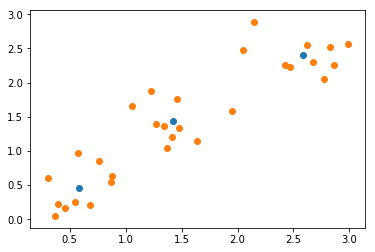

In [413]:
k = 3
points = []
for i in range(k):
    points.extend(np.random.rand(10, 2) + i)

points = np.array(points)
labels, centroids = iter_kmeans(points, k)

plt.scatter(centroids[:, 0], centroids[:, 1])
plt.scatter(points[:, 0], points[:, 1])

In [309]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [310]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])

In [299]:
mask_0 = np.where(y_train == 0)
mask_1 = np.where(y_train == 1)

In [354]:
sub_x_train = np.concatenate((x_train[mask_0][:10], x_train[mask_1][:10]))

In [356]:
sub_x_train.shape

(20, 784)

In [422]:
labels, centroids = iter_kmeans(sub_x_train, 2, epochs=10000)

/Users/pascalluttgens/.pyenv/versions/anaconda3-4.4.0/envs/clustering/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/pascalluttgens/.pyenv/versions/anaconda3-4.4.0/envs/clustering/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [423]:
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

([array([1., 0., 0., 0., 0., 1., 0., 0., 0., 3.]),
  array([3., 0., 0., 0., 0., 1., 0., 0., 0., 1.])],
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 2 Lists of Patches objects>)

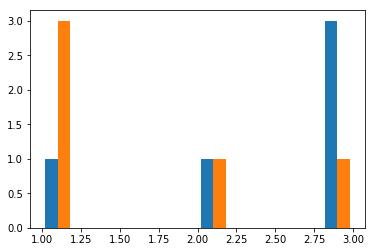

In [401]:
plt.hist([[1,3,3,3, 2], [1,2,3, 1, 1]])